# 1.- Objetivo
El alumno **descargará el/los corpus** que desee (detalle sobre los datos a utilizar en el siguiente punto) y realizará un **análisis exploratorio** de los datos.

Este ejercicio deberá contener: 
- Cardinalidad del vocabulario
- Distribución de reviews por número de estrellas
- Nº de reviews positivas y negativas
- N-grams más frecuentes
- Nubes de palabras
- Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)
- Conclusiones de la exploración
- Cualquier otra métrica / exploración / cálculo que el alumno considere

# 1.1.- Configuración

In [1]:
!pip install wget==3.2
!pip install nltk==3.7
!pip install WordCloud
!pip install gensim==4.1.2

You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [2]:
# Variables globales

# Descargar el archivo de la página
descargar_corpus_and_rating = False

# Plotear la nube de palabras
plot_could_words = True

# Entrenar los modelos Word2Vec y guardarlos
train_word2vec_models = False

# Archivos elegidos
["reviews_Home_and_Kitchen_5", "reviews_Tools_and_Home_Improvement_5"]

# Semilla
seed = 52 # Referencia friki

# 1.2.- Descarga y descompresión
Vamos a realizar la descarga y la descompresión de los archivos mediante terminal directamente

In [3]:
import os
import wget
import gzip
import shutil

In [4]:
# Creo carpeta Corpus
! mkdir Corpus

Ya existe el subdirectorio o el archivo Corpus.


In [5]:
# Descarga de Corpus
if descargar_corpus_and_rating:
    wget.download("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz")
    wget.download("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Tools_and_Home_Improvement_5.json.gz")

In [6]:
# Descomprimir y mover archivos
if descargar_corpus_and_rating:
    with gzip.open("reviews_Home_and_Kitchen_5.json.gz", 'rb') as infile:
        with open("./Corpus/reviews_Home_and_Kitchen_5.json", 'wb') as outfile:
            for line in infile:
                outfile.write(line)
    with gzip.open("reviews_Tools_and_Home_Improvement_5.json.gz", 'rb') as infile:
        with open("./Corpus/reviews_Tools_and_Home_Improvement_5.json", 'wb') as outfile:
            for line in infile:
                outfile.write(line)

In [7]:
# Borra los archivos gz
if descargar_corpus_and_rating:
    os.remove("reviews_Home_and_Kitchen_5.json.gz")
    os.remove("reviews_Tools_and_Home_Improvement_5.json.gz")

# 1.3.- Importamos y unimos nuestros datos en un solo dataset

In [8]:
# Librerías necesarias
import json
import pandas as pd
import itertools

In [9]:
# Función para importar el dataset (mediante generador)
def get_json_data(file):
    for line in open(file):
        yield json.loads(line)

In [10]:
# Variables
corpus_path = "./Corpus/"
file1 = corpus_path + "reviews_Home_and_Kitchen_5.json"
file2 = corpus_path + "reviews_Tools_and_Home_Improvement_5.json"
n_samples = 100000

In [11]:
# Importación y unión de los datasets
df = pd.concat([pd.DataFrame(itertools.islice(get_json_data(file1),n_samples)), 
                pd.DataFrame(itertools.islice(get_json_data(file2),n_samples))],
               axis=0, ignore_index=True)

In [12]:
# Comprobamos nuestros datos
print("df.shape: {}\n".format(df.shape))
print(df.dtypes)

df.shape: (200000, 9)

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


In [13]:
# Nos deshacemos de columnas que no son de interés
cols_to_drop = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "summary"]
df.drop(columns=cols_to_drop, inplace=True)

In [14]:
# Comprobamos nuestros datos
df.head()

,reviewText,overall
0,My daughter wanted this book and the price on ...,5.0
1,I bought this zoku quick pop for my daughterr ...,5.0
2,There is no shortage of pop recipes available ...,4.0
3,This book is a must have if you get a Zoku (wh...,5.0
4,This cookbook is great. I have really enjoyed...,4.0


## 1.4.- Exploración

### 1.4.1.- Contabilización (sin ningun procesamiento) para visualizar con que datos iniciamos
Se va a usar generadores para no consumir Ram, la idea es solo contabilizar para comparar

In [15]:
# Palabras (División por espacios)
tokens = (token for sentence in df[["reviewText"]].values for token in sentence[0].split())
print("Palabras: {}\n".format(len(list(tokens))))

Palabras: 19643722



In [16]:
# Frases (División por punto)
sentences = (token for sentence in df[["reviewText"]].values for token in sentence[0].split('.'))
print("Frases: {}\n".format(len(list(sentences))))

Frases: 1534006



### 1.4.2.- Procesado de los datos

In [17]:
import nltk
import numpy as np

* **Tokenizado** (a nivel de frase)

In [18]:
# Librerías necesarias
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonyz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# función
def tokenizer_sentence_level(reviews, tonkenizer=nltk.tokenize.sent_tokenize):
    for review in reviews:
        yield tonkenizer(review[0])

In [20]:
# Procesado
reviews_sentences = tokenizer_sentence_level(df[["reviewText"]].values)
print(next(
    tokenizer_sentence_level(df[["reviewText"]].values)
))

['My daughter wanted this book and the price on Amazon was the best.', 'She has already tried one recipe a day after receiving the book.', 'She seems happy with it.']


* **Tokenizado** (a nivel de palabra y quitando puntuación)

In [21]:
# Librerías necesarias
from nltk import RegexpTokenizer

In [22]:
# función
def tokenizer_word_level(reviews, tokenizer=nltk.RegexpTokenizer(r'\w+')):
    for review in reviews:
        yield tokenizer.tokenize(review[0])

In [23]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
print(next(corpus))

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', 'She', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', 'She', 'seems', 'happy', 'with', 'it']


* **Normalizado de palabra** (Paso a minúsculas)

In [24]:
# función
def corpus_to_lower(reviews):
    for review in reviews:
        yield [word.lower() for word in review]  

In [25]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = corpus_to_lower(corpus)
print(next(corpus))

['my', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'amazon', 'was', 'the', 'best', 'she', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', 'she', 'seems', 'happy', 'with', 'it']


* **Stop Words**

Dado que vamos a analizar sentimiento, no vamos a usar stopwords (o no al menos la lista entera) en los siguientes puntos, pero si no valdrá para visualizar

In [26]:
# Bajamos las stopwords de nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tonyz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Elegimos las stopwords en inglés
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [28]:
# función
def drop_stopwords(reviews, stopwords=nltk.corpus.stopwords.words('english')):
    for review in reviews:
        yield [word for word in review if word not in stopwords] 

In [29]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = drop_stopwords(corpus)
print(next(corpus))

['My', 'daughter', 'wanted', 'book', 'price', 'Amazon', 'best', 'She', 'already', 'tried', 'one', 'recipe', 'day', 'receiving', 'book', 'She', 'seems', 'happy']


* **Stemming**

In [30]:
# Librerías necesarias
from nltk.stem.snowball import EnglishStemmer

In [31]:
# Función
def stemming_data(reviews, stemmer=nltk.stem.snowball.EnglishStemmer(ignore_stopwords=True)):
    for review in reviews:
        yield [stemmer.stem(word) for word in review]

In [32]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = stemming_data(corpus)
print(next(corpus))

['my', 'daughter', 'want', 'this', 'book', 'and', 'the', 'price', 'on', 'amazon', 'was', 'the', 'best', 'she', 'has', 'alreadi', 'tri', 'one', 'recip', 'a', 'day', 'after', 'receiv', 'the', 'book', 'she', 'seem', 'happi', 'with', 'it']


* **Lemmatization**

In [33]:
# Librerías necesarias
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tonyz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tonyz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
# Función
def lemmatizing_data(reviews, lemmatizer=nltk.stem.WordNetLemmatizer()):
    for review in reviews:
        yield [lemmatizer.lemmatize(word) for word in review]

In [35]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = lemmatizing_data(corpus)
print(next(corpus))

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'wa', 'the', 'best', 'She', 'ha', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', 'She', 'seems', 'happy', 'with', 'it']


* **Excluyendo palabras aplha == False**

In [36]:
# Función
def cleaning_no_alpha(reviews):
    for review in reviews:
        yield [word for word in review if str.isalpha(word)]

In [37]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = cleaning_no_alpha(corpus)
print(next(corpus))

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', 'She', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', 'She', 'seems', 'happy', 'with', 'it']


### 1.4.3.- Conteo, bolsa de palabras y N-Gramas

* **Bag of words**

In [38]:
# Librerías necesarias
from collections import Counter
import matplotlib.pyplot as plt

In [39]:
# Definición de funciones (1/2)

# extrae las palabras del corpus
def get_words(corpus):
    return [word for review in corpus for word in review]

# extrae el vocabulario
def get_alphabet(words):
    return set(words)

# frecuencia de cada palabra
def get_frequency(words):
    return Counter(words)

# Las n palabras mas comunes
def get_most_commons(words, n=15):
    return Counter(words).most_common(20)

In [40]:
# Definición de funciones (2/2)

# Plot Bag of Words
def plot_bag_of_words(corpus):
    
    # extrae las palabras del corpus
    words = get_words(corpus)
    
    # Las n palabras mas comunes
    wf_most_common = get_most_commons(words, 20)
    
    # Devuelve la bolsa de palabras ordenada
    bow = zip(*sorted(zip([w[0] for w in wf_most_common],
                          [w[1] for w in wf_most_common]), 
                      key=lambda x: x[1]))
    
    # Plot
    plt.barh(*bow)
    plt.show()

In [41]:
# Nuestro corpus para el BoW
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = corpus_to_lower(corpus)
corpus = drop_stopwords(corpus)
corpus = lemmatizing_data(corpus)
corpus = list(cleaning_no_alpha(corpus))

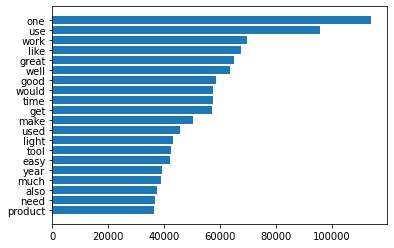

In [42]:
plot_bag_of_words(corpus)

Esta gráfica ya nos da una idea de que cosas son las mas comentadas, por ejemplo el uso (use) o que funcione (work), parece ser cosas importantes en nuestro dataset

* **N-Grams** (2 y 3)

In [43]:
# Librerías necesarias
from nltk import ngrams
from nltk.probability import FreqDist

In [44]:
# Creamos una función para simplificar
def get_n_grams(words, n=2):
    
    # creación de ngramas
    ngrams_ = list(ngrams(words, n))
    
    # FreqDist para cada ngramas
    ng_freq = FreqDist(ngrams_)
    
    return ngrams_, ng_freq

# Ploteamos nuestros ngramas mas comunes
def plot_most_commons(words, n_words=2, n_most_common=20):
    
    _, ng_freq = get_n_grams(words, n_words)
    
    # Los más comunes
    ng_freq_most_common = ng_freq.most_common(n_most_common)
    
    # parseamos
    ngs_ = [str(ng[0]) for ng in ng_freq_most_common]
    
    # Las frecuencias de los más comunes
    ngs_f_ = [ng[1] for ng in ng_freq_most_common]
    
    # Empaquetamos
    ngs_f_, ngs_ = zip(*sorted(zip(ngs_f_, ngs_)))
    
    # Ploteamos
    plt.barh(ngs_, ngs_f_)
    plt.title('{}_gram frequencies'.format(n_words))
    plt.show()

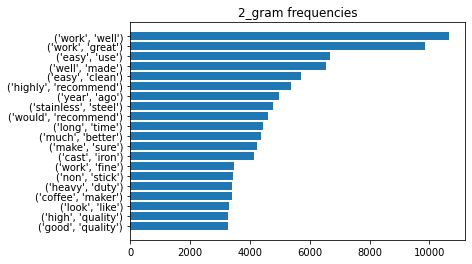

In [45]:
plot_most_commons(get_words(corpus), n_words=2, n_most_common=20)

En los bigramas podemos ver cosas curiosas como que "ice cream" sale mucho, esto es en parte porque estas 2 palabras siempre salen unidas ya que es compuesta, podmeos sacar conclusiones tambien de la importancia de que funciones bien "work well" o que esté bien hecho "well made"

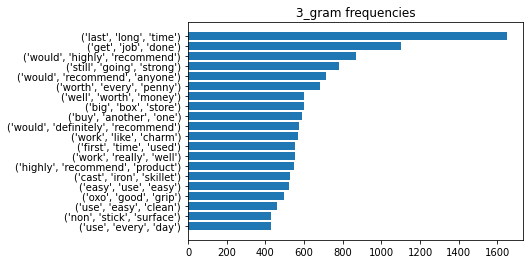

In [46]:
plot_most_commons(get_words(corpus), n_words=3, n_most_common=20)

En trigramas, vemos como "oxo good grip" es la más comentada, buscando un poco descubrí que estas 3 palabras son debido a una marca de utensilios de cocinas, quitando esto podemos ver como salen palabras como heladeras, o que hagan bien el trabajo

* **Nube de palabras**

In [47]:
# Librerías necesarias
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [48]:
# Nube de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

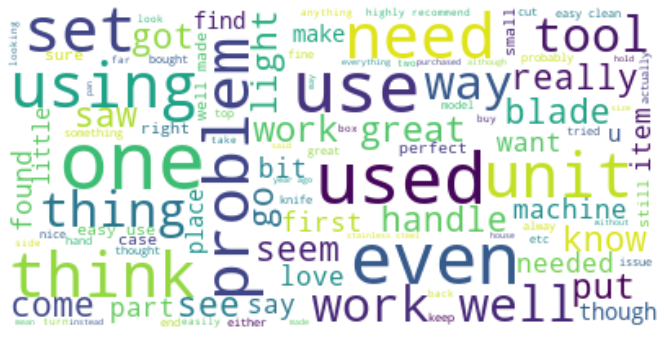

In [49]:
if plot_could_words:
    plot_word_cloud(get_words(corpus))

La nube de palabras nos da información de forma muy visual, podemos ver conceptos como necesidad, uso, funcionamiento, tamaño (en concreto pequeño) o cosas mas específicas como blade (hoja)

### 1.4.3.- Exploración respecto a sentimiento
Hemos estado analizando nuestro dataset con respecto al exto en si, vamos a empezar a mirar las estrellas y reviews positivas o negativas

* **Distribución de reviews por número de estrellas**

array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

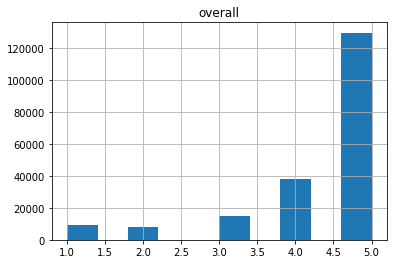

In [50]:
# Histograma para ver la distribución
df[["overall"]].hist()

Tenemos un problema con este dataset y es que nuestros datos no están balanceados, podriamos intentar balancearlos poniendo que 4 estrellas es una puntuación negativa, pero no creo que fuera realista pero de cara a empresa siendo muy críticos quizás pueda tener sentido

* **Número de reviews positivas y negativas**

In [51]:
# Función
def sentiment(row):
    return 0 if int(row[['overall']]) < 4 else 1

In [52]:
# Creamos nuestra columna de sentimiento
df['sentiment'] = df.apply(lambda row: sentiment(row), axis=1)

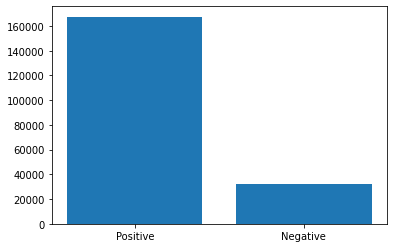

In [53]:
# Mostramos
plt.bar(["Positive", "Negative"], 
        [df[df["sentiment"] == 1]["sentiment"].count(),
         df[df["sentiment"] == 0]["sentiment"].count()])
plt.show()

In [54]:
# Corpus positivo
corpus_positive = tokenizer_word_level(df[df["sentiment"] == 1][["reviewText"]].values)
corpus_positive = corpus_to_lower(corpus_positive)
corpus_positive = drop_stopwords(corpus_positive)
corpus_positive = lemmatizing_data(corpus_positive)
corpus_positive = list(cleaning_no_alpha(corpus_positive))

# Corpus negativo
corpus_negative = tokenizer_word_level(df[df["sentiment"] == 0][["reviewText"]].values)
corpus_negative = corpus_to_lower(corpus_negative)
corpus_negative = drop_stopwords(corpus_negative)
corpus_negative = lemmatizing_data(corpus_negative)
corpus_negative = list(cleaning_no_alpha(corpus_negative))

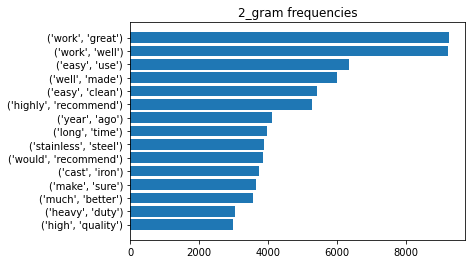

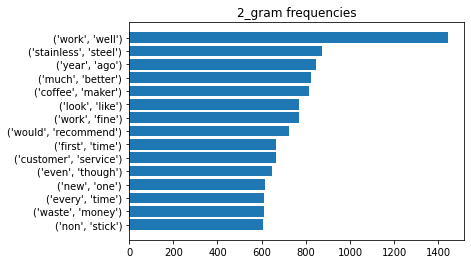

In [55]:
plot_most_commons(get_words(corpus_positive), n_words=2, n_most_common=15)
plot_most_commons(get_words(corpus_negative), n_words=2, n_most_common=15)

En este caso, se puede ver alguna que otra diferencia en cuanto sentimiento, por ejemplo "waste money" en el negativo o "would recommend" en vez de "highly recommend", y por algún motivo como curiosidad aparece acero inoxidable

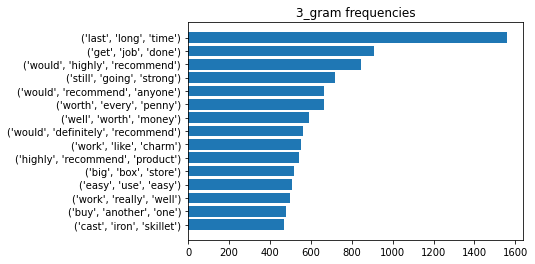

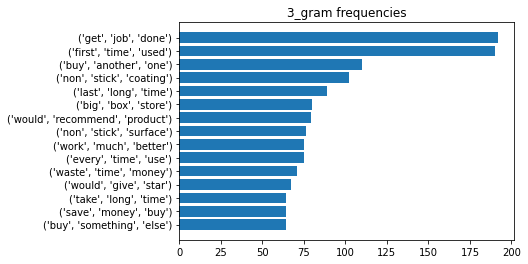

In [56]:
plot_most_commons(get_words(corpus_positive), n_words=3, n_most_common=15)
plot_most_commons(get_words(corpus_negative), n_words=3, n_most_common=15)

En los trigramas podemos ver sentimientos también diferenciados, frases como "buy another one" o "every time use" da que pensar al respecto

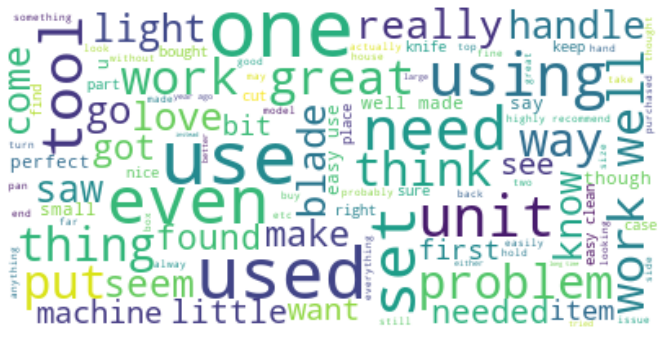

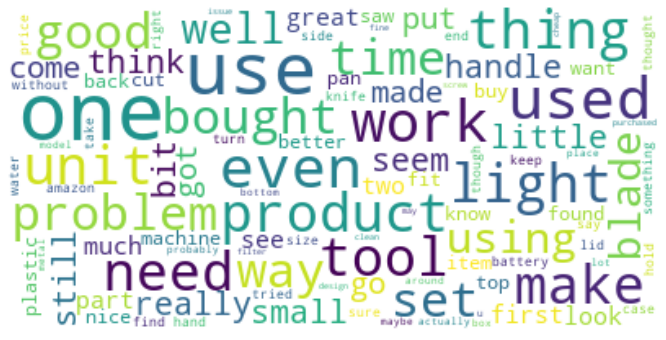

In [57]:
if plot_could_words:
    plot_word_cloud(get_words(corpus_positive))
    plot_word_cloud(get_words(corpus_negative))

### 1.4.4.- Word embedding

In [58]:
# gensim==4.1.2
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

* **Hyperparameters**

In [59]:
if train_word2vec_models:
    sg_params = {
        'vector_size': 200,
        'window': 10,
        'min_count': 5,
        'sg': 1,
        'hs': 0,
        'negative': 20,
        'workers' : 6,
        'seed' : seed
    }

    cbow_params = {
        'vector_size': 200,
        'window': 10,
        'min_count': 5,
        'sg': 0,
        'hs': 0,
        'negative': 20,
        'workers' : 6,
        'seed' : seed
    }

* **Iniciamos los objetos Word2Vec**

In [60]:
if train_word2vec_models:
    # Skip Gram
    w2v_sg = Word2Vec(**sg_params)

    # CBOW
    w2v_cbow = Word2Vec(**cbow_params)

* **Construimos el vocabulario**

In [61]:
if train_word2vec_models:
    # Skip Gram
    w2v_sg.build_vocab(corpus)

    # CBOW
    w2v_cbow.build_vocab(corpus)

    print('Vocabulario compuesto por {} palabras'.format(len(w2v_sg.wv.key_to_index)))
    print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv.key_to_index)))

Vocabulario compuesto por 23180 palabras
Vocabulario compuesto por 23180 palabras


* **Entrenamos los pesos**

In [62]:
# Callbacks para ir visualizando el proceso
if train_word2vec_models:
    class callback(CallbackAny2Vec):
        '''Callback to print loss after each epoch.'''

        def __init__(self):
            self.epoch = 0

        def on_epoch_end(self, model):
            cum_loss = model.get_latest_training_loss()
            if self.epoch == 0:
                print('Loss after epoch {}: {}'.format(self.epoch, cum_loss))
            else:
                print('Loss after epoch {}: {}'.format(self.epoch, cum_loss - self.loss_previous_step))
            self.epoch += 1
            self.loss_previous_step = cum_loss

In [63]:
if train_word2vec_models:
    # Skip Gram
    w2v_sg.train(corpus, total_examples=w2v_sg.corpus_count, epochs=7, compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 38346768.0
Loss after epoch 1: 31072368.0
Loss after epoch 2: 8498696.0
Loss after epoch 3: 8036240.0
Loss after epoch 4: 7101800.0
Loss after epoch 5: 6926752.0
Loss after epoch 6: 6525088.0


In [64]:
if train_word2vec_models:
    # CBOW
    w2v_cbow.train(corpus, total_examples=w2v_cbow.corpus_count, epochs=7, compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 4524876.5
Loss after epoch 1: 3892803.5
Loss after epoch 2: 3581351.0
Loss after epoch 3: 3586127.0
Loss after epoch 4: 3433090.0
Loss after epoch 5: 3235378.0
Loss after epoch 6: 3201434.0


* **Guardamos los modelos** (o los cargamos)

In [67]:
if train_word2vec_models:
    !mkdir Models
    w2v_sg.save('./Models/w2v_sg.pkl')
    w2v_cbow.save('./Models/w2v_cbow.pkl')
else:
    w2v_sg = Word2Vec.load('./Models/w2v_sg.pkl')
    w2v_cbow = Word2Vec.load('./Models/w2v_cbow.pkl')

* **Resultados**

In [68]:
words_to_test = ["blade", "money", "great", "waste", "use"]

In [69]:
def print_sim_words(word, model1, model2):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for (sim1, sim2) in zip(model1.wv.most_similar(word), model2.wv.most_similar(word)):
        print("{}:{}{:.3f}{}{}:{}{:.3f}".format(sim1[0],
                                               " "*(20-len(sim1[0])), 
                                               sim1[1], 
                                               " "*10, 
                                               sim2[0],
                                               " "*(20-len(sim2[0])),
                                               sim2[1]))
    print("\n")

In [70]:
[print_sim_words(word, w2v_cbow, w2v_sg) for word in words_to_test]

Most similar to blade
---------------------
teeth:               0.639          cutting:             0.621
serration:           0.583          kerf:                0.614
stroke:              0.578          cut:                 0.610
carbide:             0.573          saw:                 0.607
axe:                 0.564          knife:               0.596
tooth:               0.556          woodcutting:         0.595
kerf:                0.552          blad:                0.586
knife:               0.551          sawblade:            0.575
bladed:              0.547          avanti:              0.574
sharpness:           0.541          fastback:            0.571


Most similar to money
---------------------
cash:                0.762          monies:              0.675
aggravation:         0.657          buck:                0.665
buck:                0.632          expesive:            0.624
fortune:             0.609          cost:                0.620
grief:               0.564  

[None, None, None, None, None]

Parece que no funciona mal la similitud entre palabras, vamos a visualizar en 2D en el siguiente punto, para una mejor representación

### 1.4.5.- Visualización 2D

* **Cluster**

In [71]:
embedding_clusters = []
word_clusters = []

for word in words_to_test:
    embeddings = []
    words = []
    
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [72]:
print(word_clusters)

[['cutting', 'kerf', 'cut', 'saw', 'knife', 'woodcutting', 'blad', 'sawblade', 'avanti', 'fastback'], ['monies', 'buck', 'expesive', 'cost', 'expensive', 'dollar', 'cash', 'buy', 'angst', 'equiptment'], ['good', 'excellent', 'nice', 'perfect', 'well', 'really', 'love', 'like', 'fine', 'also'], ['wasted', 'wasting', 'save', 'waster', 'garbage', 'poc', 'colossal', 'junk', 'spent', 'saving'], ['using', 'used', 'need', 'also', 'work', 'since', 'however', 'one', 'great', 'even']]


* **Reducción de dimensionalidad a 2D**

In [73]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np

In [74]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [75]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [76]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [77]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

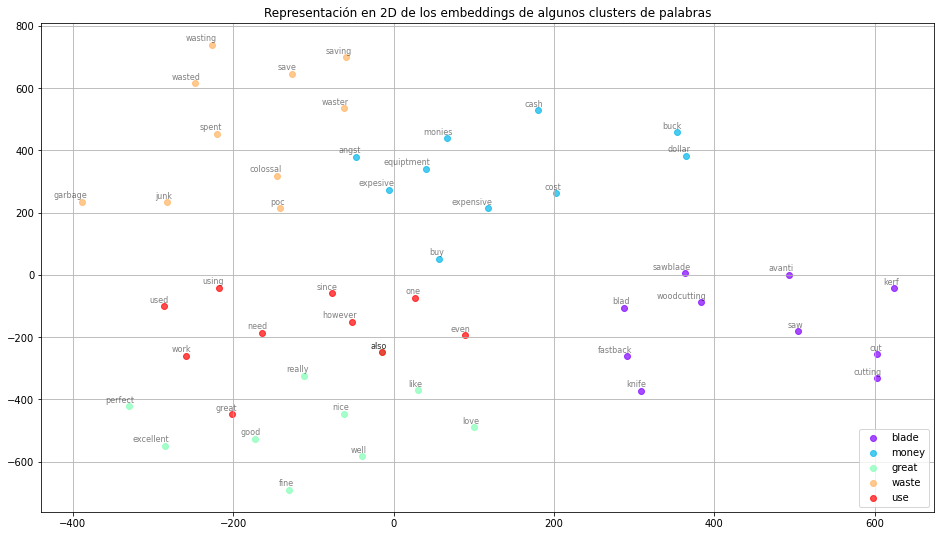

In [78]:
tsne_plot_similar_words(words_to_test, embeddings_2d, word_clusters)

Bien, en general podemos ver que distingue bien entre los diferentes clusters, aunque vemos que 'waste' y 'money' están bastante cerca entre si, lo cual es lógico, podemos ver sentimientos positivos con el cluster de 'great' y como se relaciona de forma cercana con el uso, como work o really

In [79]:
embedding_clusters = []
word_clusters = []

for word in words_to_test:
    embeddings = []
    words = []
    
    for similar_word, _ in w2v_cbow.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_cbow.wv[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [80]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [81]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


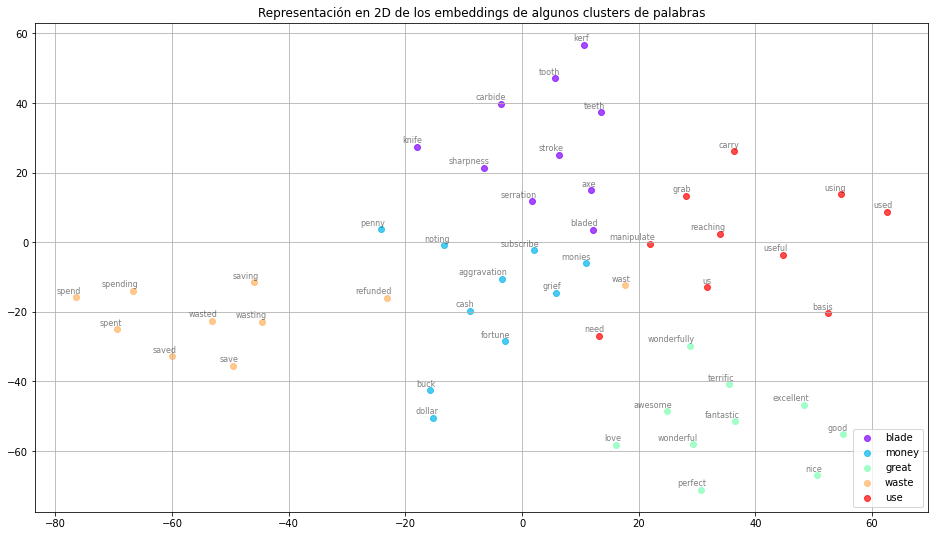

In [82]:
tsne_plot_similar_words(words_to_test, embeddings_2d, word_clusters)

En CBOW parece los clusters un poco mas caóticos que en Skip-gram, aquí podemos darnos cuenta que las cosas positiva "great" están alejadas y diferenciadas del resto, podemos ver también "waste" y "money" en ocaciones se mezclan, también comprobamos que el cluster de 'use' está bastante disperso, una pequeña curiosidad que podemos ver, es que money, wast y bladed están bastante cerca, lo cual puede significar que en general las cuchillas se asocian de forma negativa respecto al dinero